__Purpose:__ Test the performance of already trained decoders to see if they continue to achieve the best performance, and to see if personalization is necessary/possible.  Ideally, this NB should show that the outputs of previous training rounds will maintain their high performance.  I am ambivalent about whether or not we would expect any further improvement over training.

In [1]:
import pandas as pd
import os
import numpy as np
np.random.seed(0)
import random
random.seed(0)
from matplotlib import pyplot as plt
from scipy.optimize import minimize
import copy

#import seaborn as sns
#from presentation_sns_config import *

from experiment_params import *
from cost_funcs import *
from fl_sim_client import *
from fl_sim_server import *
import time
import pickle
from sklearn.decomposition import PCA

from scipy.optimize import minimize, least_squares
from itertools import permutations

In [2]:
path = r'C:\Users\kdmen\Desktop\Research\Data'
cond0_filename = r'\cond0_dict_list.p'
all_decs_init_filename = r'\all_decs_init.p'
nofl_decs_filename = r'\nofl_decs.p'
id2color = {0:'lightcoral', 1:'maroon', 2:'chocolate', 3:'darkorange', 4:'gold', 5:'olive', 6:'olivedrab', 
            7:'lawngreen', 8:'aquamarine', 9:'deepskyblue', 10:'steelblue', 11:'violet', 12:'darkorchid', 13:'deeppink'}
implemented_client_training_methods = ['EtaGradStep', 'EtaScipyMinStep', 'FullScipyMinStep']
implement_these_methods_next = ['APFL', 'AFL', 'PersA_FL_MAML', 'PersA_FL_ME', 'PFA']
num_participants = 14

# For exclusion when plotting later on
bad_nodes = [1,3,13]

# NoFL (200P)

In [59]:
# For condition 1:
alpha = .25 # higher alpha means more old decoder (slower update)
alphaD = 1e-3
alphaF = 0
first_half = 14  # Used to be 7, idk why I only wanted to use half
total_num_updates = 19
final_training_update = 15
starting_update = 0 # This is not used anywhere else except directly below FYI 
num_updates = final_training_update - starting_update
dt = 1/60

#############################################################

cost_df = pd.read_csv(r"C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\599_PrivacyAnalysis\Poster_Plotting\200P_train_cost_df.csv")
test_cost_df = pd.read_csv(r"C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\599_PrivacyAnalysis\Poster_Plotting\200P_test_cost_df.csv")
test_cost_df_postSB = pd.read_csv(r"C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\599_PrivacyAnalysis\Poster_Plotting\200P_test_cost_df_postSB.csv")

print(cost_df.shape)
cost_df.drop('Unnamed: 0', axis=1, inplace=True)

print(test_cost_df.shape)
test_cost_df.drop('Unnamed: 0', axis=1, inplace=True)

print(test_cost_df_postSB.shape)
test_cost_df_postSB.drop('Unnamed: 0', axis=1, inplace=True)

(15, 16)
(15, 16)
(15, 16)


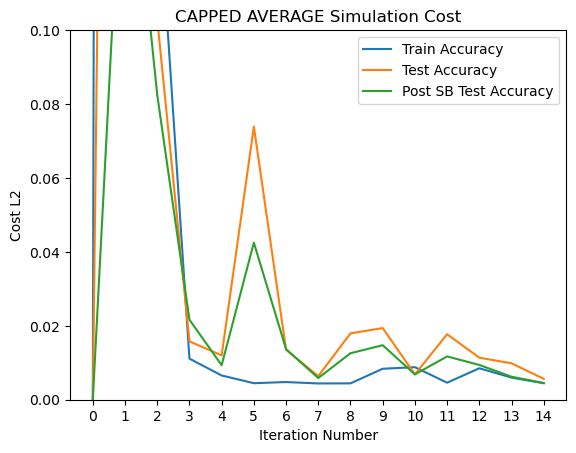

In [63]:
step_indices = list(range(num_updates))
plt.plot(cost_df.iloc[-1,:], label="Train Accuracy")
plt.plot(test_cost_df.iloc[-1,:], label="Test Accuracy")
plt.plot(test_cost_df_postSB.iloc[-1,:], label="Post SB Test Accuracy")
    
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('CAPPED AVERAGE Simulation Cost')
plt.ylim(0, 0.1)
plt.legend()
plt.show()

# Federated Learning
## 1 Scipy Step, 600 Iterations
> Note that the thicker, lighter lines are the global model accuracies, whereas the thin lines are the local accuracies.

In [ ]:
with open(path+cond0_filename, 'rb') as fp:
    cond0_training_and_labels_lst = pickle.load(fp)
    
with open(path+all_decs_init_filename, 'rb') as fp:
    init_decoders = pickle.load(fp)
cond0_init_decs = [dec[0, :, :] for dec in init_decoders]

D_0 = np.random.rand(2,64)
D_0_10 = np.random.rand(2,10)

In [50]:
user_c0_1ScipyStep = [Client(i, D_0_10, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', starting_update=0, set_alphaF_zero=True, delay_scaling=0, verbose=True) for i in range(14)]
global_model_1scipystep = Server(1, D_0_10, 'FedAvg', user_c0_1ScipyStep)

big_loop_iters = 600
for i in range(big_loop_iters):
    global_model_1scipystep.execute_FL_loop()


Client 1: New update after lrt passed: (new update, current global round, current local round): (1, 125, 50)

Client 1: New update after lrt passed: (new update, current global round, current local round): (2, 259, 100)

Client 1: New update after lrt passed: (new update, current global round, current local round): (3, 385, 150)

Client 1: New update after lrt passed: (new update, current global round, current local round): (4, 512, 200)



In [51]:
id2color = {0:'lightcoral', 1:'maroon', 2:'chocolate', 3:'darkorange', 4:'gold', 5:'olive', 6:'olivedrab', 
        7:'lawngreen', 8:'aquamarine', 9:'deepskyblue', 10:'steelblue', 11:'violet', 12:'darkorchid', 13:'deeppink'}

def moving_average(numbers, window_size):
    i = 0
    moving_averages = []
    while i < len(numbers) - window_size + 1:
        this_window = numbers[i : i + window_size]

        window_average = sum(this_window) / window_size
        moving_averages.append(window_average)
        i += window_size
    return moving_averages

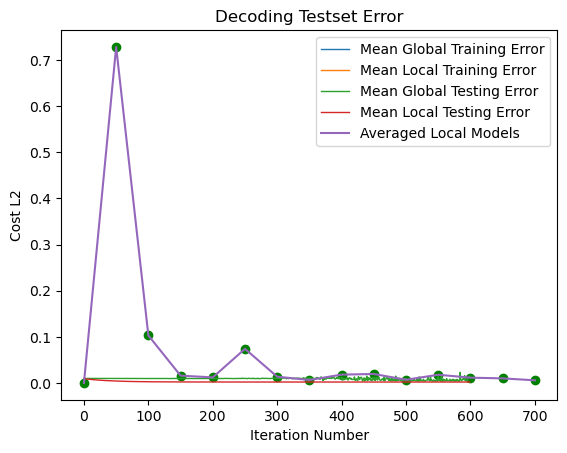

In [76]:
my_title = 'Decoding Testset Error'
#iterable_labels=['Averaged Global Models', 'Averaged Fine-Tuned Models']
iterable_labels = []


#all_users, all_dfs, all_vecs = central_tendency_plotting([user_nofl_rand_init, user_c0_no_fl_w_cphs_init, user_c0_no_fl_wclient_init], iterable_labels=['Shared Random Init', 'CPHS Init', 'Prev Client Inits'])
all_user_input = [user_c0_1ScipyStep]

plot_mean=True
plot_median=False
exclusion_ID_lst=[]
dim_reduc_factor=1
#plot_gradient=False
#plot_pers_gradient=False
plot_this_ID_only=-1
#plot_global_gradient=False
global_error=True
local_error=True
#pers_error=False
different_local_round_thresh_per_client=False
legend_on=True
num_participants=14
show_update_change=True
custom_title=""
axes_off_list=[]
xlim_max=None
xlim_min=None
ylim_max=None
ylim_min=None
input_linewidth=1
my_legend_loc='best'
iterable_colors=[]

plot_testing = True
plot_training = True


#def central_tendency_plotting(all_user_input, highlight_default=False, default_local=False, default_global=False, default_pers=False, plot_mean=True, plot_median=False, exclusion_ID_lst=[], dim_reduc_factor=1, plot_gradient=False, plot_pers_gradient=False, plot_this_ID_only=-1, plot_global_gradient=False, global_error=True, local_error=True, pers_error=False, different_local_round_thresh_per_client=False, legend_on=True, plot_performance=False, plot_Dnorm=False, plot_Fnorm=False, num_participants=14, show_update_change=True, custom_title="", axes_off_list=[], xlim_max=None, xlim_min=None, ylim_max=None, ylim_min=None, input_linewidth=1, my_legend_loc='best', iterable_labels=[], iterable_colors=[]):
num_central_tendencies = 2  # Mean and median... idk, maybe use flags or something...
if dim_reduc_factor!=1:
    raise ValueError("dim_reduc_factor MUST EQUAL 1!")

global_training_df = pd.DataFrame()
local_training_df = pd.DataFrame()
global_testing_df = pd.DataFrame()
local_testing_df = pd.DataFrame()

param_list = [False, False, False, (global_error and plot_training), (local_error and plot_training), False, False, False, False, (global_error and plot_testing), (local_error and plot_testing)]
all_vecs_dict = dict()
all_vecX_dict = dict()
for param_idx, param in enumerate(param_list):
    all_vecs_dict[param_idx] = [[] for _ in range(num_central_tendencies)]
    all_vecX_dict[param_idx] = [[] for _ in range(num_central_tendencies)]
param_label_dict = {0:'Gradient', 1:'Personalized Gradient', 2:'Global Gradient', 3:'Global Training Error', 4:'Local Training Error', 5:'Personalized Error', 6:'Performance', 7:'DNorm', 8:'FNorm', 9:'Global Testing Error', 10:'Local Testing Error'}
tendency_label_dict = {0:'Mean', 1:'Pseudo-Median'}

max_local_iters = 0
label_idx = 0
for user_idx, user_database in enumerate(all_user_input):
    for i in range(len(user_database)):
        # Skip over users that distort the scale
        if user_database[i].ID in exclusion_ID_lst:
            continue 
        elif len(user_database[i].local_error_log)<2:
            # This node never trained so just skip it so it doesn't break the plotting
            continue 
        else: 
            # This is used for plotting later
            if plot_training:
                if len(user_database[i].local_error_log) > max_local_iters:
                    max_local_iters = len(user_database[i].local_error_log)
                if global_error:  # or (user_idx==0 and default_global==True):
                    df = pd.DataFrame(user_database[i].global_error_log)
                    global_training_df = pd.concat([global_training_df, (df.groupby(df.index//dim_reduc_factor, axis=0).mean()).T])
                if local_error:  # or (user_idx==0 and default_local==True):
                    df = pd.DataFrame(user_database[i].local_error_log)
                    local_training_df = pd.concat([local_training_df, (df.groupby(df.index//dim_reduc_factor, axis=0).mean()).T])
            if plot_testing:
                if len(user_database[i].local_test_error_log) > max_local_iters:
                    max_local_iters = len(user_database[i].local_test_error_log)
                if global_error:  # or (user_idx==0 and default_global==True):
                    df = pd.DataFrame(user_database[i].global_test_error_log)
                    global_testing_df = pd.concat([global_testing_df, (df.groupby(df.index//dim_reduc_factor, axis=0).mean()).T])
                if local_error:  # or (user_idx==0 and default_local==True):
                    df = pd.DataFrame(user_database[i].local_test_error_log)
                    local_testing_df = pd.concat([local_testing_df, (df.groupby(df.index//dim_reduc_factor, axis=0).mean()).T])

    # Bad temporary soln for MVP
    #all_dfs_dict = {0:grad_df.reset_index(drop=True), 1:pers_grad_df.reset_index(drop=True), 2:global_grad_df.reset_index(drop=True), 3:global_df.reset_index(drop=True), 4:local_df.reset_index(drop=True), 5:pers_df.reset_index(drop=True), 6:perf_df.reset_index(drop=True), 7:dnorm_df.reset_index(drop=True), 8:fnorm_df.reset_index(drop=True)}
    all_dfs_dict = {0:0, 1:1, 2:2, 3:global_df.reset_index(drop=True), 4:local_df.reset_index(drop=True), 5:5, 6:6, 7:7, 8:8, 9:global_testing_df.reset_index(drop=True), 10:local_testing_df.reset_index(drop=True)}

    for flag_idx, plotting_flag in enumerate(param_list):
        if plotting_flag:
            my_df = all_dfs_dict[flag_idx]
            if plot_mean:
                all_vecs_dict[flag_idx][0] = my_df.mean()
            if plot_median:
                all_vecs_dict[flag_idx][1] = my_df.median()
    
    my_alpha = 1
    my_linewidth = input_linewidth
    for flag_idx, plotting_flag in enumerate(param_list):
        if plotting_flag:
            my_vec = all_vecs_dict[flag_idx]
            for vec_idx, vec_vec in enumerate(my_vec):
                if (plot_mean==True and vec_idx==0) or (plot_median==True and vec_idx==1):
                    if iterable_labels!=[]:
                        my_label = iterable_labels[label_idx]
                        label_idx += 1
                    else:
                        my_label = f"{tendency_label_dict[vec_idx]} {param_label_dict[flag_idx]}"
                    if "GLOBAL:" in my_label.upper():
                        my_linestyle = 'dashed'
                    elif "LOCAL:" in my_label.upper():
                        my_linestyle = 'solid'
                    elif "PERS:" in my_label.upper():
                        my_linestyle = 'dotted'
                    else:
                        my_linestyle = 'solid'
                    #my_alpha = 0.4 if (highlight_default and user_idx==0) else 1
                    #my_linewidth = 5 if (highlight_default and user_idx==0) else input_linewidth
                    #print(f"flag_idx, plotting_flag: {(flag_idx, plotting_flag)}")
                    #print(f"vec_idx: {vec_idx}")
                    #print(f"len(vec_vec): {len(vec_vec)}")
                    #print(f"np.sum(vec_vec): {np.sum(vec_vec)}\n")
                    saved_vec = np.array(vec_vec)
                    plt.plot(range(len(vec_vec)), vec_vec, label=my_label, alpha=my_alpha, linewidth=my_linewidth, linestyle=my_linestyle)

# NoFL Scaled Plot
scaled_step_indices = np.array(step_indices)*50 # Maybe ought to use 100...
#plt.plot(cost_df.iloc[-1,:], label="Train Accuracy")
plt.plot(scaled_step_indices, test_cost_df.iloc[-1,:], label="Averaged Local Models")
plt.scatter(scaled_step_indices, test_cost_df.iloc[-1,:], color='green')
#plt.plot(test_cost_df_postSB.iloc[-1,:], label="Post SB Test Accuracy")
                                          
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title(my_title)
#num_ticks = 5
#plt.xticks(ticks=np.linspace(0,max_local_iters,num_ticks,dtype=int))
#plt.xlim((0,max_local_iters+1))
#plt.ylim(0, 0.1)
plt.legend(loc=my_legend_loc)
plt.show()